<a href="https://colab.research.google.com/github/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/blob/main/Basic%20CNN%20Autoencoder/BasicCNNAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Convolutional Neural Network AutoEncoder notebook**

# **cell for installing a module or package**

# **Necessary Import for our notebook**

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav
from IPython.display import Audio
#from sound import sound

## **Function to convert signal audio vector to tensor**

In [70]:
def signal2pytorch(x):
   #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
   #Argument x: a 1-d signal as numpy array
   #input x[batch,sample]
   #output: 3-d Tensor X for conv1d input.
   #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
   X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
   if len(x.shape)==1: #mono:
      X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
   X=torch.from_numpy(X)
   X=X.type(torch.Tensor)
   X=X.permute(1,0,2)  #make batch dimension first
   return X

# **Convolution autoencoder class consist of encoder,decoder,and forward propogation function**

In [71]:
class Convautoenc(nn.Module):
   def __init__(self):
      super(Convautoenc, self).__init__()
      #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
      self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

      #Synthesis filter bank:
      self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

   def encoder(self, x):
      #Analysis:
      x = self.conv1(x)
      y = torch.tanh(x)
      return y
      
   def decoder(self, y):
      #Synthesis:
      xrek= self.synconv1(y)
      return xrek
      
   def forward(self, x):
      y=self.encoder(x)
      #y=torch.round(y/0.125)*0.125
      xrek=self.decoder(y)
      return xrek

# **Loading of Track16.wav file from github**

In [72]:
!wget https://raw.githubusercontent.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/main/Track16.wav
print('Track16.wav loaded')

--2020-10-27 21:06:31--  https://raw.githubusercontent.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/main/Track16.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790336 (1.7M) [audio/wav]
Saving to: ‘Track16.wav.2’

Track16.wav.2       100%[===================>]   1.71M  11.0MB/s    in 0.2s    

2020-10-27 21:06:31 (11.0 MB/s) - ‘Track16.wav.2’ saved [1790336/1790336]

Track16.wav loaded


# **Processing and training of audio data with left channel**

In [ ]:
filename = 'Track16.wav'
fs, audio = wav.read(filename)

#make it mono left channel
audio0=audio[:,0] 

#make it mono right channel
audio1=audio[:,1] 

#normalization of left audio channel
audio0=audio0*1.0/np.max(np.abs(audio0))
print("audio0.shape=", audio0.shape)

#normalization of right audio channel 
audio1=audio1*1.0/np.max(np.abs(audio1))
print("audio1.shape=", audio1.shape)

#Convert to pytorch format, (training with right audio channel)
X=signal2pytorch(audio1)    

print("Generate Model:")
model = Convautoenc()

print("Def. loss function:")
loss_fn = nn.MSELoss()

# It is an unsupervised training so there is no target signal,we will use input signal for getting target values.
Ypred=model(X)

#length of the signal at the output of the network.
outputlen=len(Ypred[0,0,:]) 
print("outputlen=", outputlen)

#the target signal with same length as model output
Y=X[:,:,:outputlen]  

print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)

print("Y.type()=", Y.type())


learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred=model(X)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
print("Ypred.shape=", Ypred.shape)

In [82]:
losses = np.zeros(1999)
for epoch in range(2000):
          Ypred=model(X)
          loss=loss_fn(Ypred, Y)
          losses[epoch - 1] = loss.item()
          if epoch%10==0:
             print(epoch, loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

0 0.03602954372763634
10 0.03528208285570145
20 0.034191180020570755
30 0.03282911330461502
40 0.031425539404153824
50 0.030094051733613014
60 0.028858544304966927
70 0.027710359543561935
80 0.026638077571988106
90 0.025631221011281013
100 0.024679064750671387
110 0.023772139102220535
120 0.022903641685843468
130 0.022069470956921577
140 0.021267784759402275
150 0.02049841545522213
160 0.01976214163005352
170 0.019060170277953148
180 0.01839343085885048
190 0.017762409523129463
200 0.017166845500469208
210 0.01660574972629547
220 0.0160776786506176
230 0.01558074913918972
240 0.015112808905541897
250 0.01467159390449524
260 0.0142549779266119
270 0.01386091485619545
280 0.013487576507031918
290 0.013133284635841846
300 0.012796572409570217
310 0.012476131319999695
320 0.012170807458460331
330 0.011879567988216877
340 0.011601497419178486
350 0.01133580133318901
360 0.011081761680543423
370 0.01083875261247158
380 0.010606196708977222
390 0.010383551008999348
400 0.010170286521315575
41

In [83]:
print(range(epoch))
print(losses)

range(0, 1999)
[0.03595665 0.03588587 0.03581619 ... 0.00316876 0.00316809 0.00316743]


# **Graph with the number of epochs vs the training loss**

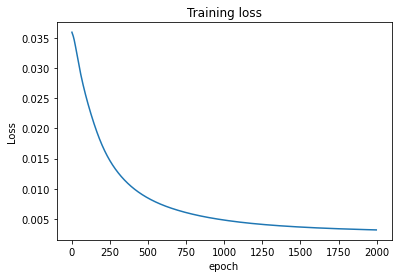

In [84]:
plt.figure(1)

plt.plot(range(epoch),losses)
plt.title('Training loss');
plt.xlabel('epoch'); plt.ylabel('Loss');
plt.show()

# **Testing of the model with left audio Channel**

In [85]:
Audio(audio0,rate=fs)

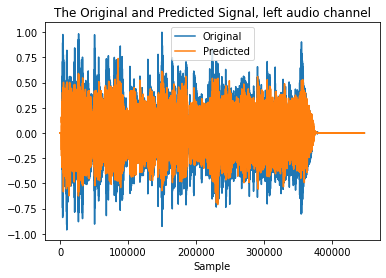

In [88]:
#Convert to pytorch format (testing with left audio channel)
X_test=signal2pytorch(audio0)

# Make Predictions based on the obtained weights, on left audio channel(test audio)
#Y=X[:,:,:outputlen] 
predictions=model(X_test) 
#print(predictions.shape,X_test.shape)
predictions=predictions.detach()
predictions=np.array(predictions)

plt.plot(np.array(X_test[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal, left audio channel')
plt.xlabel('Sample')
plt.show()

xrek=predictions[0,0,:]

In [89]:
Audio(xrek,rate=fs)

# **mean squared error between the original test audio signal, and the predicted (the reconstructed) audio signal.**

In [90]:
#converting predictions to torch.tensor from numpy array
predictions = torch.from_numpy(predictions)
#print(predictions.shape,X_test.shape)
length=len(predictions[0,0,:]) 
print("len=", length)

#for calculating mean square error loss both should be of samelength(Test audio signal and reconstructed signal)
OriginalTestAudio=X_test[:,:,:outputlen] 
print(predictions.shape,OriginalTestAudio.shape)

#calculating loss function between original test audio signal and predicted (the reconstructed) audio signal
loss=loss_fn(predictions, OriginalTestAudio)
print('MSE Loss:',loss.item())

len= 447490
torch.Size([1, 1, 447490]) torch.Size([1, 1, 447490])
MSE Loss: 0.034068502485752106
